This lab is probably going to be a bit harder. If you have a question, please post it on the [piazza page](https://piazza.com/class/jr23imb6nqr2az), since somebody else will likely have the same question, and you'll get a response faster. 

# Lab 7: Probabilistic Programming

So up until now, we've been working on neural networks. However, another school of though in machine learning is with probabilistic graphical models. In PGMs, we propose a generative process that our data arose from. A generative process can be thought of as a composition of probability distributions (rather than a composition of linear and non-linear transformations in a neural network). We then learn the parameters for the process that best fit the data. These parameters form the *posterior* distribution. 

There are many ways to do define a probabilistic program. Most models can actually be coded manually. (if you take Foundations of Graphical Models with David Blei, you'll have to do that!) This can be a tedious process, but fortunately for us, we can take advantage of probabilistic programming languages. These systems greatly simplify the process of defining a model, and performing inference on said model. 

In Computational Methods, our probabilistic programming language of choice will be pyro. Pyro sits on top of pytorch, and since we're all experts in pytorch by now, this seems like the logical next step. If you haven't already, install pyro into your `Computational_methods` environment. A note on installation, you can only install pyro by doing `pip install pyro-ppl`. As long as you have pip installed in your conda environment, it will still install everything in that environment as well, where it will be accessible to your `CM_19` jupyter notebook kernel. 

Interestingly, pyro was developed by Uber AI to help assign drivers to riders, and pick the most efficient routes for their car hailing service. So next time you need a ride home from the East Village at 4 AM, you can thank probabilistic programming! Enough rambling, onto the lab.

In [25]:
import torch
import pyro
import matplotlib.pyplot as plt

## Part 1: Pyro Basics - Sampling and Conditioning

While the basic unit in a neural network is an artificial neuron, a basic "unit" in a probabilistic graphical model is a stochastic function. Stochastic functions allow your to model uncertainty, in a Bayesian perspective. Philisophically, this may be a better way to view real world events. Is anything ever truly certain...?  

Let's examine a simple model (lifted directly from the [pyro tutorial](http://pyro.ai/examples/intro_part_i.html#Primitive-Stochastic-Functions))

In [5]:
def weather(p_cloudy):
    is_cloudy = pyro.sample("is_cloudy", pyro.distributions.Bernoulli(p_cloudy))
    
    if is_cloudy:
        loc, scale = 55.0, 10.0
        sky = "cloudy"
    else:
        loc, scale = 75.0, 15.0
        sky = "sunny"
    
    temperature = pyro.sample("temp", pyro.distributions.Normal(loc, scale))
    return sky, temperature

for _ in range(3):
    print(weather(.3))

('sunny', tensor(65.6177))
('sunny', tensor(73.9583))
('sunny', tensor(86.6018))


The `pyro.sample` method is similar to sampling from a distribution in the `torch.distribution` package. The key difference is that the object created from a call to `pyro.sample` is *named*. This allows pyro to control what happens to it at runtime, and do other magic tricks that we'll get to later. 

### Define your own model

**Here's another example.** A nanodrop is an instrument used to measure the concentration of DNA or protein in a small droplet of liquid. These things are notoriously inaccurate, and are sometimes referred to as "random number generators." Make a function that produces a noisy estimate for DNA concentration by sampling from a normal distribution with standard deviation 5. As an input, it takes the amount of DNA that you *meant* to pipette. Pipettes also have a margin of error (Say normally distributed with variance 1), so model that into function as well. 

In [23]:
def nanodrop(guess): # The concentration of DNA you think you're pipetting
    actual_amount = pyro.sample("amount", pyro.distributions.Normal(guess, 1))
    reading = pyro.sample("reading", pyro.distributions.Normal(actual_amount, 5))# The concentration that you actually have, and what we're interested in estimating
    return reading # an output called 'reading'

print("The DNA concentration is totally {} ng/uL".format(nanodrop(50)))

# See why I quit benchwork to do bioinformatics?

The DNA concentration is totally 45.186134338378906 ng/uL


As a graphical model, `nanodrop` looks like this:


<img src="https://jeinson.github.io/images/nanodrop_model.png" alt="gradient_descent" style="width: 200px;"/>


Where z = `guess`, y = `actual_amount`, and x = `reading`. 
\begin{align*}
y &\sim N(z, \sigma_0) \\
x &\sim N(y, \sigma_1)
\end{align*}

Pipette what you think is 50 ng/$\mu$L of DNA 100 times, measure it with `nanodrop`, then plot a histogram of readings to get a feel for the distribution. 

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   2.,   1.,   6.,   4.,
          1.,   6.,   1.,  13.,  13.,  16.,  18.,  20.,  32.,  26.,  40.,
         51.,  47.,  66.,  76.,  76.,  96., 131., 133., 144., 188., 200.,
        216., 212., 248., 252., 249., 294., 293., 317., 319., 347., 344.,
        354., 355., 340., 323., 337., 319., 270., 309., 284., 257., 253.,
        242., 237., 166., 197., 173., 127., 136., 130., 106.,  79.,  78.,
         63.,  68.,  45.,  47.,  32.,  31.,  27.,  26.,  16.,  14.,  10.,
          8.,   4.,   5.,  10.,   7.,   5.,   3.,   0.,   4.,   1.,   0.,
          1.]),
 array([25.419437, 25.854422, 26.289406, 26.72439 , 27.159374, 27.594357,
        28.02934 , 28.464325, 28.89931 , 29.334293, 29.769278, 30.204262,
        30.639246, 31.07423 , 31.509214, 31.944199, 32.37918 , 32.814167,
        33.24915 , 33.684135, 34.119118, 34.5541  , 34.989086, 35.42407 ,
        35.859055, 36.

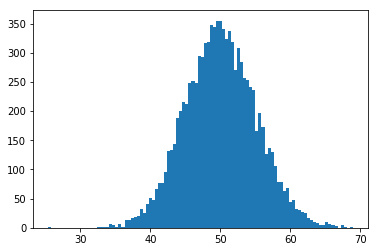

In [34]:
readings = []
for i in range(10000):
    readings.append(nanodrop(50))
    
plt.hist(readings, bins=100)

### Conditioning

Another big advantage of pyro is the ability to sample from your model when constraining on some sample statement. Basically, this means we can fix one of the parameters in the model, then draw samples from the new conditional distributrion. This is especially useful in sampling based inference methods, like MCMC. 

Measure another 100 DNA samples with `nanodrop`, but this time fix the `actual_amount` parameter to 50, and plot the results. Make sure to use [`pyro.condition`](http://pyro.ai/examples/intro_part_ii.html#Conditioning). You will have to supply a value for `guess`, but does this actually change anything?

TypeError: '<' not supported between instances of 'function' and 'float'

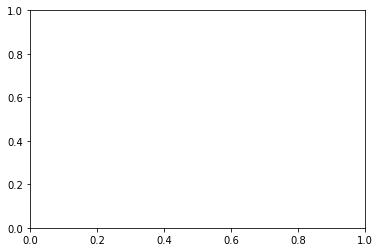

In [38]:
readings = []
for i in range(1000):
    readings.append(pyro.condition(50, data={"amount": 50}))
    
plt.hist(readings, bins=100)

### Guide functions

Another major player in the pyro pipeline is the guide function. The interpretation of a guide function differs between the inference method you're using, but essentially the guide function will approximate the posterior distribution for your model. This is the goal of performing *inference* on data. For variational inference, the guide function is the variational distribution. If you haven't seen this before, don't worry. We'll cover it later. 

In the case of our nanodrop model, it's easy to calculate the posterior distribution by hand, since all we really have is a gaussian with a gaussian prior. Check out this [wikipedia page](https://en.wikipedia.org/wiki/Conjugate_prior) for a list of distributions and their conjugate priors, with formulae for how to calculate their posterior hyperparameters. Conjugacy is an extremely important concept in statistical machine learning, so get familiar with these! 

Going back to our nanodrop example, we would want to condition on the observed measurements to get the distribution of the actual concentration of DNA. In real life, you can load the same sample into a nanodrop twice, and get two different readings. This is not good if you're trying to sequence the DNA, and having a specific concentration is very important. It would be helpful to know how confident you can be in the readings a nanodrop gives you. 

Define the "perfect posterior" guide function for `nanodrop` when conditioning on `reading = 50`, and draw 100 samples. How does your estimate of `actual_amount` when drawn from the posterior differ from the maximum likelihood estimate, from the observed data? Can you estimate the posterior when using more than one sample?

In [34]:
#### your code here ####

In practice, we use torch's built in infernce tools to learn the parameters for a guide distribution to approximate the posterior. You'll do that in the next part! 😎

## Part 2: Bayesian Regression

Honestly, I think the easiest way to teach this is to have you go through the tutorial on the pyro page here http://pyro.ai/examples/bayesian_regression.html. In particular, perform inference using the [Markov Chain Monte Carlo (MCMC) method](http://pyro.ai/examples/bayesian_regression_ii.html#HMC), since we haven't covered variational inference in depth yet. You can use the dataset provided in the tutorial, but feel free to use your own dataset as well. Just make sure to include it in your submission so we can run your code. Have fun!

In [ ]:
#### your code here! ####